In [1]:
import time
import numpy as np
from constants import *
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

X = np.load('normalized_actions.npy')
y = np.load('normalized_labels.npy')

labels = np.unique(y)

le = LabelEncoder()
le.fit(y)
le_y = np.array(le.transform(y))
le_y = le_y.reshape((-1, 1))

ohe = OneHotEncoder()
ohe.fit(le_y)

y = ohe.transform(le_y).toarray()

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

In [3]:
from tensorflow.keras.layers import TimeDistributed, Conv2D, Dense, ConvLSTM2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

model = Sequential(name="lstm_keras")
# model.add(Conv2D(32, (3, 3), strides=(1, 1),activation='relu', input_shape=(window_size, num_keypoints, 1)))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv1D(64, (3,), strides=(1,),activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,input_shape=(window_size, num_keypoints)))
model.add(Flatten())
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(len(labels), activation='softmax'))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "lstm_keras"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 32)            6272      
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1282      
Total params: 7,554
Trainable params: 7,554
Non-trainable params: 0
_________________________________________________________________


In [4]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC

# callbacks_list_cnlst=[EarlyStopping(monitor='acc', patience=5),
#                       ModelCheckpoint(
#                                     filepath='cnn_lstm_model.h5',
#                                     monitor='val_loss',
#                                     save_best_only=True),
#                       ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 3)
# ]

callbacks_list_cnlst=[
                      ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 3)
                     ]

from keras import optimizers
optimizer_new=optimizers.RMSprop(lr=0.01)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['acc', AUC(name='auc')])

# model_cnlst.compile(optimizer=optimizer_new,loss='binary_crossentropy',metrics=['acc'])

Using TensorFlow backend.


In [5]:
epochs = 500
batch_size = 8

time_start = time.ctime()
start_time = time.time()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                    validation_data = (X_test, y_test),
                                    callbacks = callbacks_list_cnlst)
end_time = time.time()

59 - val_loss: 0.6735 - val_acc: 0.5250 - val_auc: 0.7410
Epoch 383/500
186/186 [==============================] - 0s 2ms/sample - loss: 0.6801 - acc: 0.5699 - auc: 0.5968 - val_loss: 0.6735 - val_acc: 0.5250 - val_auc: 0.7410
Epoch 384/500
186/186 [==============================] - 0s 2ms/sample - loss: 0.6718 - acc: 0.5860 - auc: 0.6333 - val_loss: 0.6735 - val_acc: 0.5250 - val_auc: 0.7410
Epoch 385/500
186/186 [==============================] - 0s 2ms/sample - loss: 0.6795 - acc: 0.5645 - auc: 0.6054 - val_loss: 0.6735 - val_acc: 0.5250 - val_auc: 0.7410
Epoch 386/500
186/186 [==============================] - 0s 2ms/sample - loss: 0.6834 - acc: 0.5323 - auc: 0.5698 - val_loss: 0.6735 - val_acc: 0.5250 - val_auc: 0.7410
Epoch 387/500
186/186 [==============================] - 0s 2ms/sample - loss: 0.6820 - acc: 0.5591 - auc: 0.5903 - val_loss: 0.6735 - val_acc: 0.5250 - val_auc: 0.7410
Epoch 388/500
186/186 [==============================] - 0s 2ms/sample - loss: 0.6806 - acc: 0.58

In [6]:
eval_loss, eval_acc, eval_auc = model.evaluate(X_test, y_test)
print("\nTraining at %s" % time_start)
print("Total run-time: %f seconds" % (end_time - start_time))
print("LOSS:", eval_loss)
print(" ACC:", eval_acc*100, "%")
print(" AUC:", eval_auc*100, "%")

80/80 [==============================] - 0s 247us/sample - loss: 0.6735 - acc: 0.5250 - auc: 0.7410

Training at Sat Mar  6 22:37:20 2021
Total run-time: 226.127044 seconds
LOSS: 0.6734973192214966
 ACC: 52.49999761581421 %
 AUC: 74.1015613079071 %


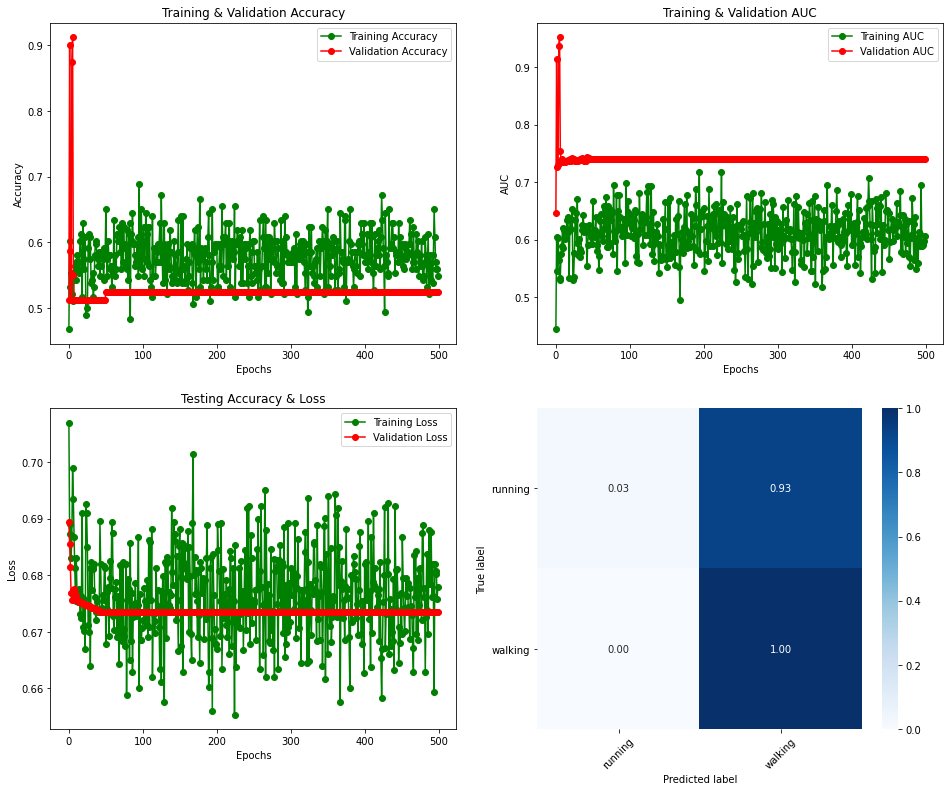

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Analysis after Model Training
dirname = 'plots'
epochs = [i for i in range(epochs)]
train_acc = history.history['acc']
train_auc = history.history['auc']
train_loss = history.history['loss']

val_acc = history.history['val_acc']
val_auc = history.history['val_auc']
val_loss = history.history['val_loss']

idx = 0
plt.rcParams['figure.figsize'] = (16, 13)
plt.subplots_adjust(hspace=0.2)

plt.subplot(2, 2, 1)
# plt.clf()
plt.plot(epochs, train_acc, 'go-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.savefig(dirname + '/' + "Acc_plot.png",
#             facecolor='w', transparent=False)

# plt.show()

plt.subplot(2, 2, 2)
# plt.clf()

plt.plot(epochs, train_auc, 'go-', label='Training AUC')
plt.plot(epochs, val_auc, 'ro-', label='Validation AUC')
plt.title('Training & Validation AUC')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("AUC")
# plt.savefig(dirname + '/' + "AUC_plot.png",
#             facecolor='w', transparent=False)
# plt.clf()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_loss, 'g-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Testing Accuracy & Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.savefig(dirname + '/' + "Loss_plot.png",
#             facecolor='w', transparent=False)
# plt.clf()

plt.subplot(2, 2, 4)
y_true = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# print(train_data.class_indices)
cm = confusion_matrix(y_true, y_pred)
# print(cm)
cm = cm / cm.astype(np.float).sum(axis=1)
# print(cm)
g = sns.heatmap(cm, annot=True, fmt='.2f', cmap="Blues",
                xticklabels=labels, yticklabels=labels)
g.set_xticklabels(g.get_xticklabels(), ha='center', rotation=45)
g.set_yticklabels(g.get_yticklabels(), rotation=0)
plt.ylabel("True label")
plt.xlabel("Predicted label")
figure = g.get_figure()
# figure.savefig(dirname + '/' + 'confusion_matrix.png',
#                 facecolor='w', transparent=False)
# plt.clf()


In [8]:
model.save("lstm_keras.h5")

In [9]:
from tensorflow.keras.models import load_model

model_loaded = load_model('lstm_keras.h5')

model_loaded.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "lstm_keras"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 32)            6272      
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1282      
Total params: 7,554
Trainable params: 7,554
Non-trainable params: 0
_________________________________________________________________
